# Goldratt's Dice Game

*Paul Bayer, 2017-07-27*

A classical illustration that dependencies and statistical fluctuations diminish the througput through a system is Goldratt's Dice Game from his business novel "The Goal".

Alex Rogo, the hero of the novel plays a game with five boys:

>*While they get go get the others, I figure out the details. The system I've set up is intended to "process" matches. It does this by moveng a quatity of match sticks out of their box, and through each of the bowls in succession. The dice determine how many matches can be moved from one bowl to the next. The dice represent the capacity of each resource, each bowl; the set of bowls are my dependent events, my stages of production. Each has exactly the same capacity as the others, but its actual yield will fluctuate somewhat.*

>*In order to keep those fluctuations minimal, however, I decide to use only one of the dice. This allows the fluctiations to range from one to six. So from the first bowl, I can move to the next bowls in line any quantity of matches ranging from a minimum of one to a maximum of six.*

>*Throughput in thos system is the speed at which matches come out of the last bowl, Inventory consists of the total number of matches in all of the bowls at any time. And I'm going to assume that market demand is exactly equal to the average number of matches that the system can process. Production capacity of each resource and market demand are perfectly in balance. So that means I now have a model of a perfectly balanced manufactoring plant.*

>*Five of the boys decide to play. Besides Dave, there are Andy, Ben, Chuck, and Evan. Each of them sits behind one of the bowls. I find some paer and a pencil to record what happens. Then I explain what they're supposed to do.*

>*"The idea is to move as many matches as you can from your bowl to the bowl on your right. When it's your turn, you roll the die, and the number that comes up is the number of matches you can move. Got it?"*

>*They all nod. "But you can only move as many matches as you've got in your bowl. So if you roll a five and you only have two matches in your bowl, then you can only move two matches. And if it comes to your turn and you don't have any matches, then naturally you can't move any."*

>*Eliyahu M Goldratt: The Goal.– 3rd ed, p. 105*

Then Rogo explains to the boys that with the die on average they should pass `3.5` matches through the system, so after twenty cycles they should have got an output of seventy.

![The Dice Game](pictures/DiceGame.png)

## A Simulation

Since we don't have enough boys as did Rogo, we have to do a simulation. But – as Julia is fast – we can do easily `100` cycles. And – according to the story – we should expect an output of `350` matches. Let's do it.

In [1]:
using SimJulia, Distributions
include("src/simlog.jl")

function boy(sim::Simulation, simlog, nr::Int64, bowls)
  roll = logvar("Boy"*string(nr), 0)         # log the die rolls
  logvar2log(simlog, roll)
  while true
    yield(Timeout(sim, 1))                   # wait until next turn
    mystock = bowls[nr]                      # how many matches are in your bowl
    roll.value = rand(DiscreteUniform(1, 6)) # roll the die
    move = min(roll.value, mystock)          # calculate how many I can move
    bowls[nr]   -= Int(move)                 # take them out from your bowl
    bowls[nr+1] += Int(move)                 # and move them to the next one
  end
end

# initalization
srand(1234)       # seed random number generator for reproducibility
simlog = newlog()
bowls = Dict(1=>999, 2=>0, 3=>0, 4=>0, 5=>0, 6=>0)      # initialize bowls with matches
dict2log(simlog, bowls, redict=Dict(1=>"Bowl1",2=>"Bowl2",3=>"Bowl3",
                                    4=>"Bowl4",5=>"Bowl5",6=>"Output")) # add them to the log
sim = Simulation()
for i = 1:5
  @process boy(sim, simlog, i, bowls)    # create 5 players
end
@process logtick(sim, simlog, 1)         # add logging after each run
run(sim, 101)                            # run simulation 
d = log2df(simlog);                      # put logged data in a dataframe
head(d)                                  # and show the first rows

,time,Bowl1,Bowl2,Bowl3,Bowl4,Bowl5,Boy1,Boy2,Boy3,Boy4,Boy5,Output
1,0,999,0,0,0,0,0,0,0,0,0,0
2,1,994,0,3,0,0,5,6,2,4,5,2
3,2,991,0,0,3,0,3,5,6,3,4,5
4,3,987,2,0,2,1,4,2,3,3,2,7
5,4,986,0,0,0,4,1,6,3,5,2,9
6,5,985,0,0,0,1,1,2,3,6,4,13


In [2]:
tail(d)                                      # show the last rows

,time,Bowl1,Bowl2,Bowl3,Bowl4,Bowl5,Boy1,Boy2,Boy3,Boy4,Boy5,Output
1,95,663,19,12,1,7,6,6,4,3,1,297
2,96,659,19,15,0,6,4,4,1,3,3,300
3,97,656,21,14,0,7,3,1,2,3,1,301
4,98,650,21,19,0,3,6,6,1,5,5,306
5,99,644,23,18,2,0,6,4,5,3,6,312
6,100,640,23,16,5,1,4,4,6,3,2,314


After `100` runs we got an output of `314` and therefore an average throughput of `3.14` matches per cycle, much less than expected. What went wrong? We had an unlimited supply of matches, a perfectly balanced line, committed players, why didn't they succeed to produce the expected outcome, but much less so?

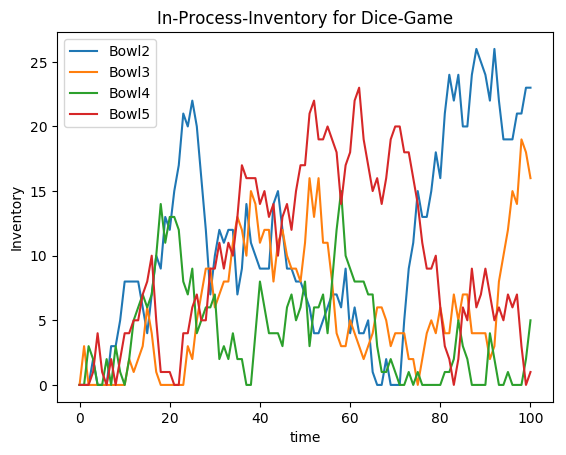

In [3]:
using PyPlot
for i in 3:6
    plot(Int.(d[:time]), d[i])
end
title("In-Process-Inventory for Dice-Game")
xlabel("time")
ylabel("Inventory")
legend(names(d)[3:6]);

Here naturally occuring fluctuations in outcomes of die rolls lead to the fact that not enough matches can be passed on in the system for further processing. So even if players down the line roll good numbers, they cannot pass on matches since they got none. Inventory builds up in the system.

## Kanban

Against too much inventory we have Kanban. So let's set the bowls of boys 2 … 5 to a maximum number – of say `10` – and do it again. Therefore we have to modify our boy function:   

In [4]:
const MAXM = 10

function boy1(sim::Simulation, simlog, nr::Int64, bowls)
  roll = logvar("Boy"*string(nr), 0)
  logvar2log(simlog, roll)
  while true
    yield(Timeout(sim, 1))
    mystock = bowls[nr]
    roll.value = rand(DiscreteUniform(1, 6))
    if nr < 5
      move = min(roll.value, mystock, MAXM - bowls[nr+1])
    else
      move = min(roll.value, mystock)
    end
    bowls[nr]   -= Int(move)
    bowls[nr+1] += Int(move)
  end
end

# initalization as above
srand(1234)       # seed random number generator for reproducibility
simlog = newlog()                            # create new log 
bowls[1] = 999                         # reset bowls
for i = 2:6
  bowls[i] = 0
end
dict2log(simlog, bowls, redict=Dict(1=>"Bowl1",2=>"Bowl2",3=>"Bowl3",
                                    4=>"Bowl4",5=>"Bowl5",6=>"Output")) # add to the new log
sim = Simulation()
for i = 1:5
  @process boy1(sim, simlog, i, bowls)       # create 5 players
end
@process logtick(sim, simlog, 1)             # add logging after each run

run(sim, 101)
d = log2df(simlog)
tail(d)

,time,Bowl1,Bowl2,Bowl3,Bowl4,Bowl5,Boy1,Boy2,Boy3,Boy4,Boy5,Output
1,95,708,5,6,1,7,6,6,4,3,1,272
2,96,704,5,9,0,6,4,4,1,3,3,275
3,97,701,7,8,0,7,3,1,2,3,1,276
4,98,698,8,9,0,3,6,6,1,5,5,281
5,99,696,9,5,2,0,6,4,5,3,6,287
6,100,695,6,3,5,1,4,4,6,3,2,289


Uups! We throttled our system further, to an output of `289` and a throughput of `2.89` matches per cycle.

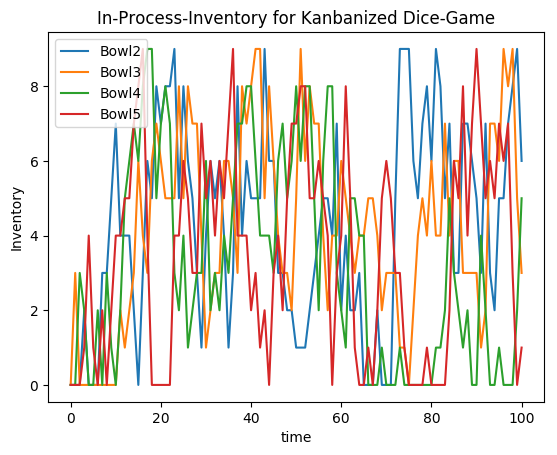

In [5]:
for i in 3:6
    plot(Int.(d[:time]), d[i])
end
title("In-Process-Inventory for Kanbanized Dice-Game")
xlabel("time")
ylabel("Inventory")
legend(names(d)[3:6]);

But we got much less inventory in the system. The throttling occurs because with Kanban in-process-inventories get more often to zero. Seemingly Kanban is no solution for our throughput problem but constrains the system further [1]. With Kanban we have reduced inpredictibility and instability in inventory. 

## Conclusion

After **variation** in the Post Office [2] we introduced with the Dice Game one further parameter into our mini-experiments with system performance: **dependencies**. 

- If we elongated our line further, to 10 or 50 stations, output would be further reduced.
- If we reduced our in-process-inventories further we would throttle the system all the more.

As in the Post Office we have a high level of fluctuations in the system – even with Kanban. And overall performance is much less than commonly ecpected. We have to get a grip on those effects.

-------------------

[1]: Even if we can experiment with bigger buffer sizes.

[2]: In the Post Office we had to tackle with the variation in arrival rates of customers. Now we have no variation in input, but big in-process-variation (the die rolls) and more dependenvies.